### HW6. Stokes second problem
### 2022313047 Boyeon,Kim

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [23]:
# Set plot params
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'calibri'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

#### Consider an infinitely extended flat wall carrying out harmonic oscillation in its own plane (see Figure 1). Due to the no-slip condition, the flow velocity at the wall (where $y = 0$) is $u(0, t) = U_0 cos(nt)$.

#### 1. (Analytic solution)
(1) Starting from the three-dimensional Navier-Stokes equations, derive the simplified governing equation for the Stokes second problem. Provide all of the assumptions that are used in your derivation. 

eq.(1)  
$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial y^2}$

#### (2) Show that the solution to the Stokes second problem is

eq.(2)  
$u(y, t) = U_0 e^{-{\eta}_s} cos(nt - \eta_s)$, where  $\eta_s = \sqrt{\frac{n}{2\nu}} y$

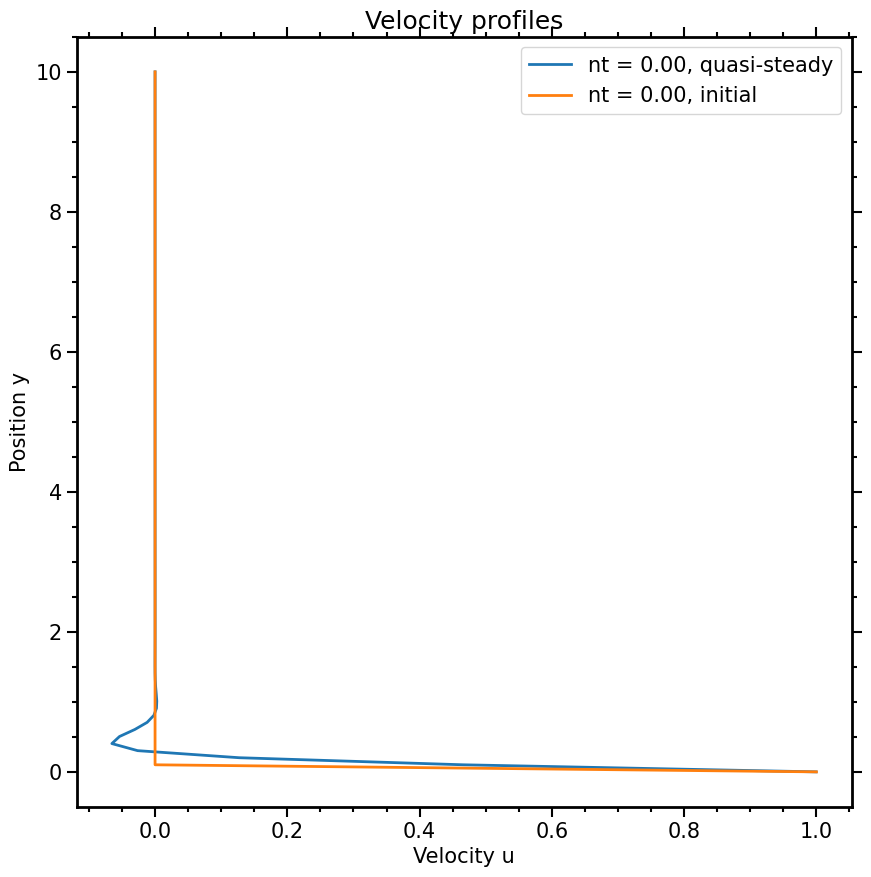

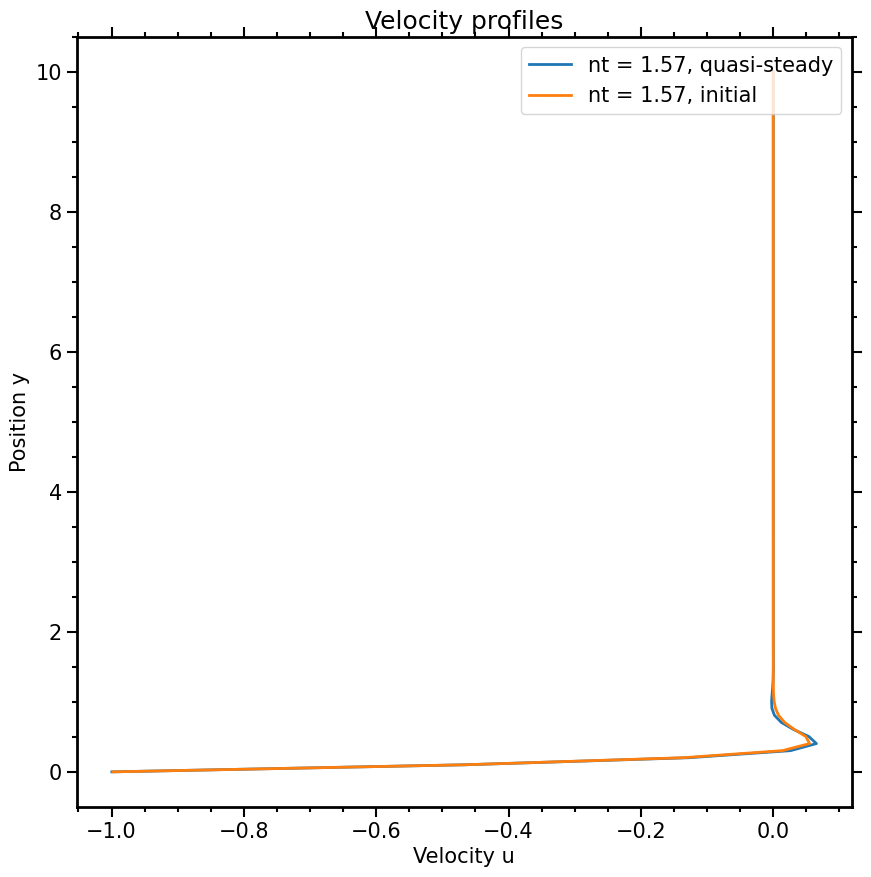

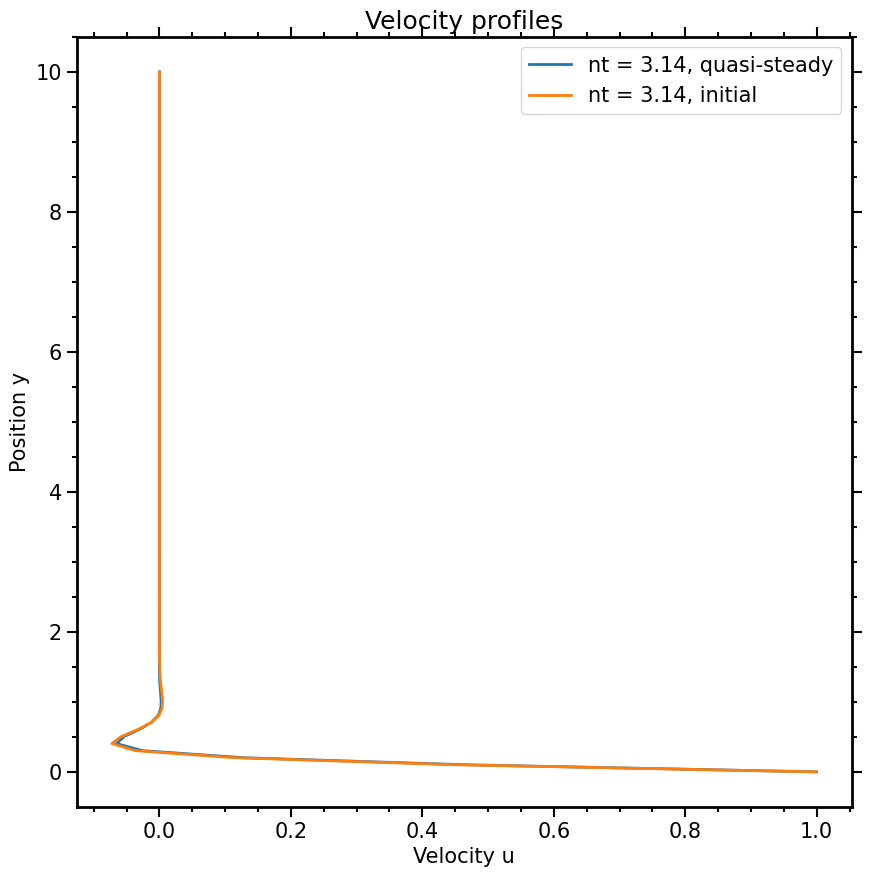

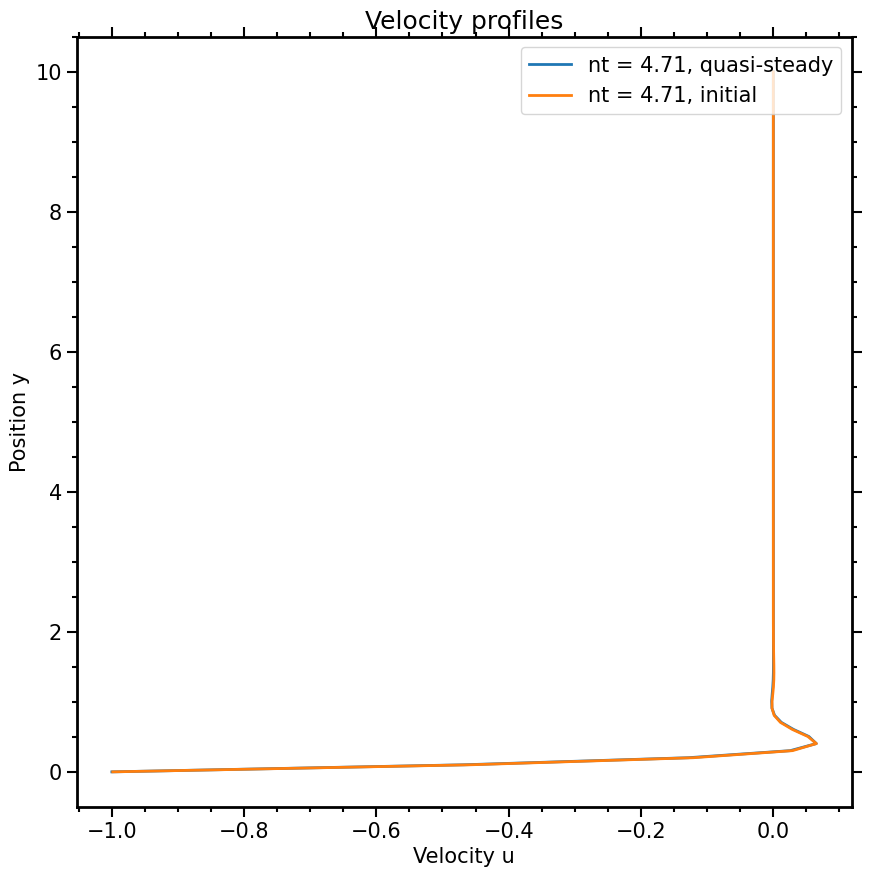

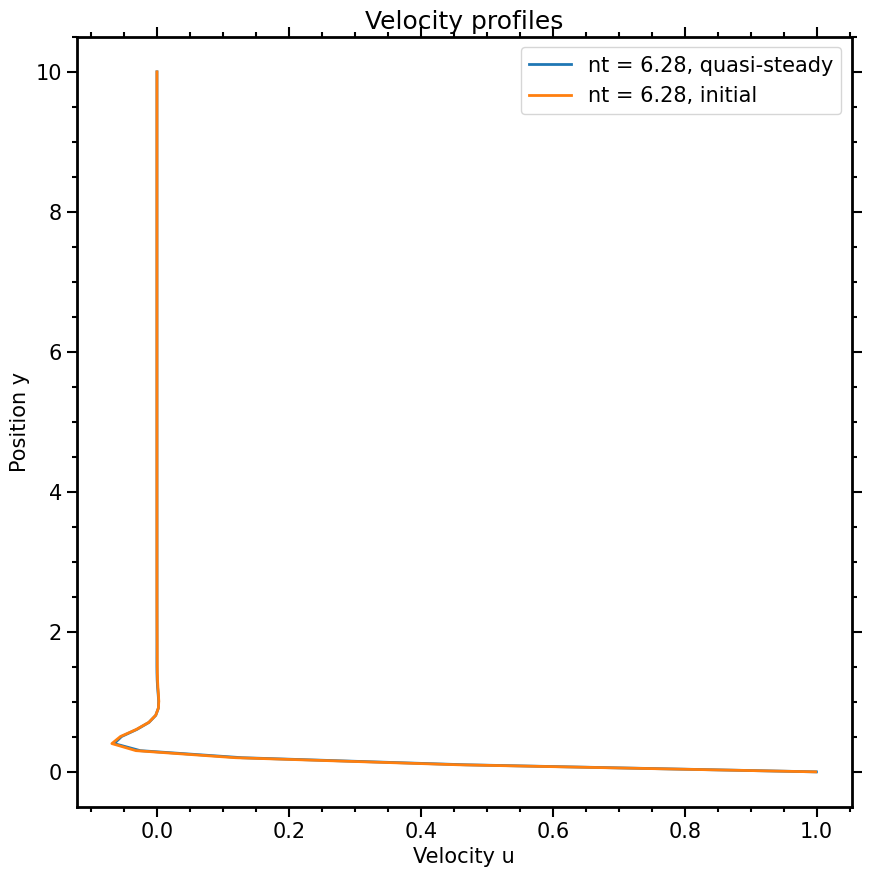

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
nu = 1
n = 2
U0 = 1
L = 10
T = 10*np.pi
nt_values = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])

# Discretization parameters
N = 100  # number of spatial points
M = 2000  # number of time points
y = np.linspace(0, L, N)
t = np.linspace(0, 2*T, M)  # extend the time to 2*T
dy = y[1] - y[0]
dt = t[1] - t[0]

# Initialize u array with boundary conditions
u = np.zeros((M, N))
u[:, 0] = np.cos(n*t)  # lower boundary condition
u[:, -1] = 0  # upper boundary condition

# FTCS scheme
for i in range(M-1):
    for j in range(1, N-1):
        delta = dy/dt
        u[i+1, j] = u[i, j] + nu * (u[i, j+1] - 2*u[i, j] + u[i, j-1]) * (1/delta)**2

# Plotting
for nt in nt_values:
    idx = int((nt+T) / dt)
    plt.plot(u[idx, :], y, label=f'nt = {nt:.2f}, quasi-steady')
    plt.plot(u[int(nt/dt), :], y, label=f'nt = {nt:.2f}, initial')
    plt.legend(loc = 'upper right')
    plt.xlabel('Velocity u')
    plt.ylabel('Position y')
    plt.title('Velocity profiles')
    plt.show()


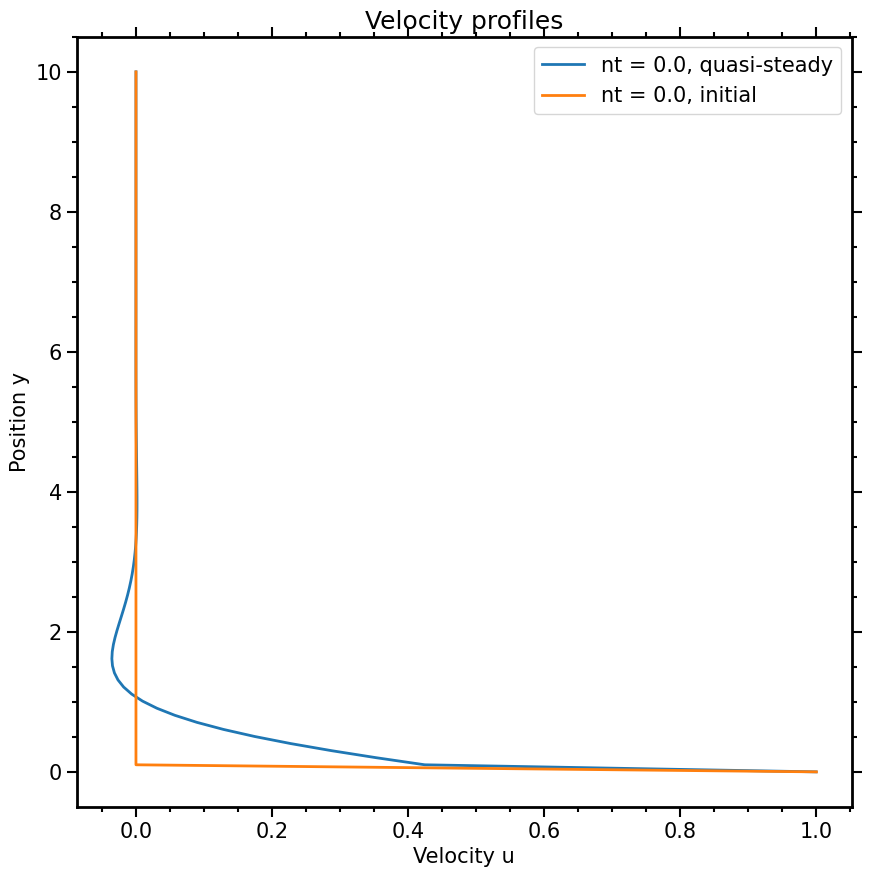

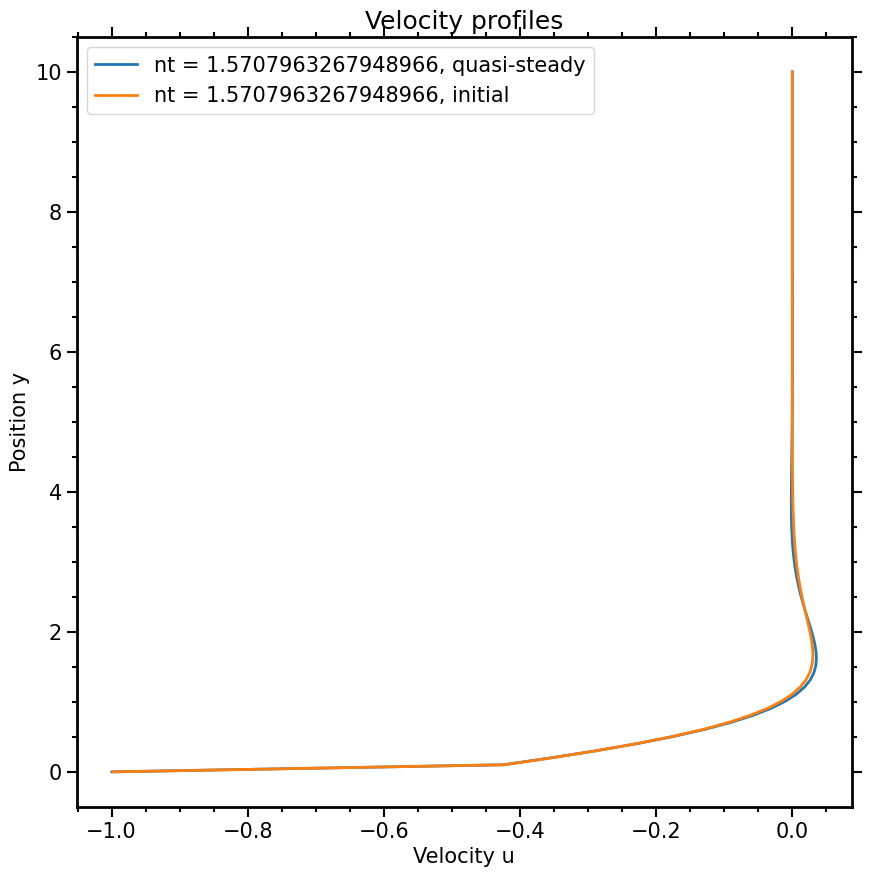

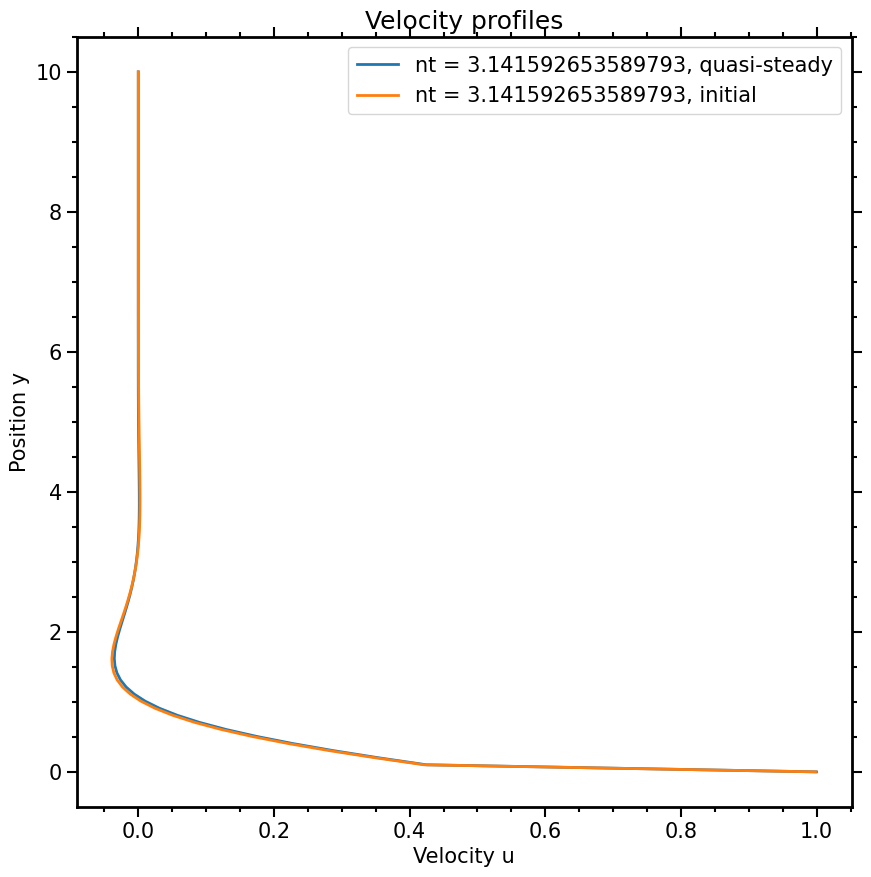

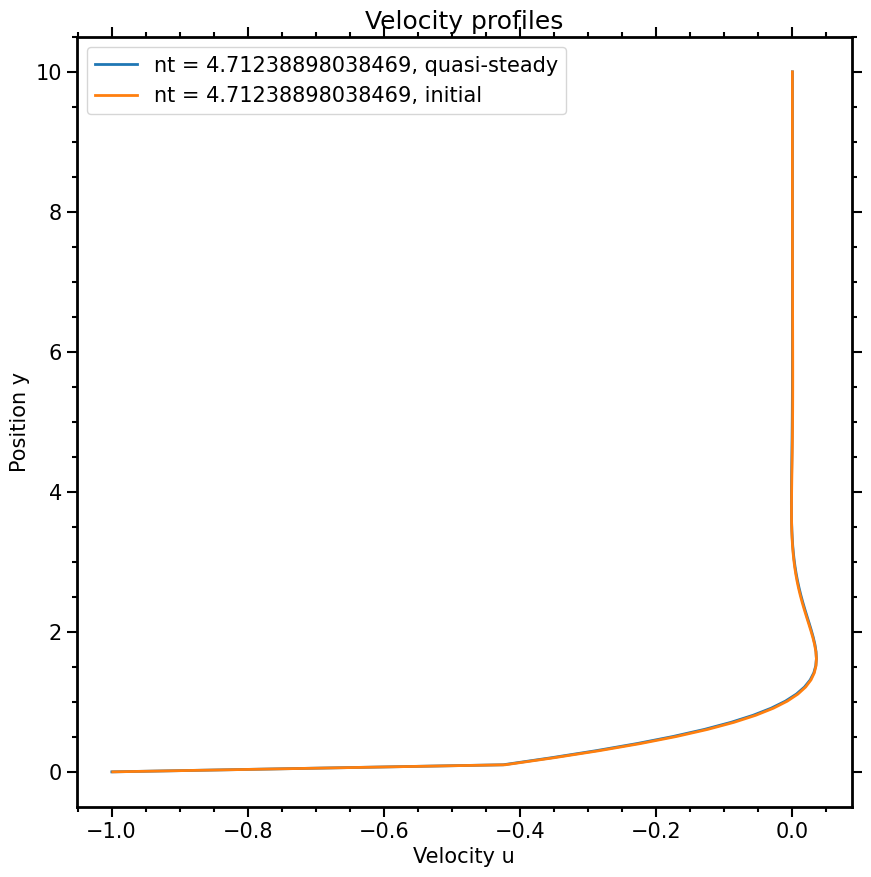

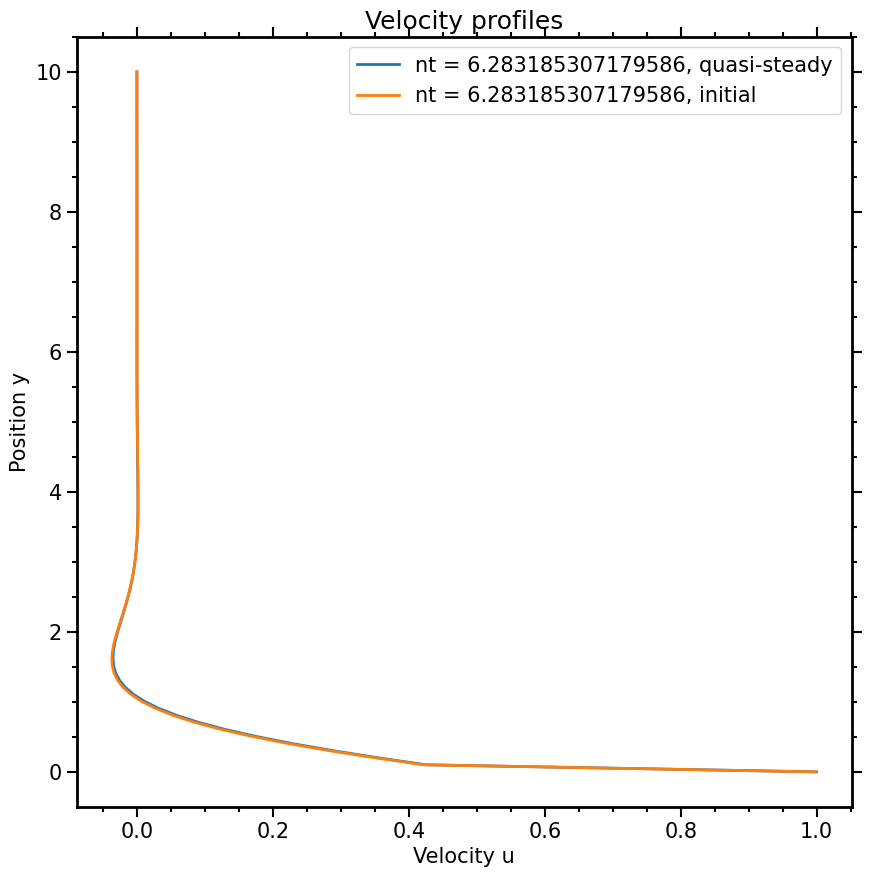

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

# Given parameters
nu = 1
n = 2
U0 = 1
L = 10
T = 10*np.pi
nt_values = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])

# Discretization parameters
N = 100  # number of spatial points
M = 2000  # number of time points
y = np.linspace(0, L, N)
t = np.linspace(0, 2*T, M)  # extend the time to 2*T
dy = y[1] - y[0]
dt = t[1] - t[0]

# Initialize u array with boundary conditions
u = np.zeros((M, N))
u[:, 0] = np.cos(n*t)  # lower boundary condition
u[:, -1] = 0  # upper boundary condition

# Crank-Nicolson scheme
for i in range(M-1):
    # Create A matrix for Crank-Nicolson
    A_upper = -nu*dt/(4*dy**2) * np.ones(N-2)
    A_mid = np.ones(N-2) + nu*dt/(2*dy**2)
    A_lower = -nu*dt/(4*dy**2) * np.ones(N-2)
    A = np.vstack((A_upper, A_mid, A_lower))
    
    # Create b vector for Crank-Nicolson
    b = u[i, 1:-1] + nu*dt/(4*dy**2) * (u[i, :-2] - 2*u[i, 1:-1] + u[i, 2:]) 
    
    # Solve Ax = b
    u[i+1, 1:-1] = solve_banded((1, 1), A, b)

# Plotting
for nt in nt_values:
    idx = int((nt+T) / dt)
    plt.plot(u[idx, :], y, label=f'nt = {nt}, quasi-steady')
    plt.plot(u[int(nt/dt), :], y, label=f'nt = {nt}, initial')
    plt.legend()
    plt.xlabel('Velocity u')
    plt.ylabel('Position y')
    plt.title('Velocity profiles')
    plt.show()


In [22]:
import numpy as np
from scipy import linalg

# Exact solution
def exact_solution(n, nu, y, t):
    ηs = np.sqrt(n/(2*nu)) * y
    return np.cos(n*t - ηs) * np.exp(-ηs)

# Calculate error
def calculate_error(numerical, exact):
    return np.abs(numerical - exact).max()

# Set parameters
nu = 1
n = 2
U0 = 1
L = 10
T = 10*np.pi
nt_values = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
N = 100
dt_values = np.array([0.001, 0.002, 0.005, 0.01])

# Initialize error arrays
error_ftcs = []
error_cn = []

# Calculate error for each dt
for dt in dt_values:
    M = int(2*T/dt)
    y = np.linspace(0, L, N)
    t = np.linspace(0, 2*T, M)
    dy = y[1] - y[0]
    
    # Exact solution
    u_exact = exact_solution(n, nu, t[:, np.newaxis], y)
    
    # Numerical solution (FTCS)
    u_ftcs = ftcs_solution(nu, n, y, t, dy, dt, M, N)  # You should replace 'ftcs_solution' with your own FTCS function
    
    # Numerical solution (Crank-Nicolson)
    u_cn = cn_solution(nu, n, y, t, dy, dt, M, N)  # You should replace 'cn_solution' with your own Crank-Nicolson function
    
    # Calculate error
    error_ftcs.append(calculate_error(u_ftcs, u_exact))
    error_cn.append(calculate_error(u_cn, u_exact))

# Calculate convergence rate
convergence_rate_ftcs = np.polyfit(np.log(dt_values), np.log(error_ftcs), 1)[0]
convergence_rate_cn = np.polyfit(np.log(dt_values), np.log(error_cn), 1)[0]

print(f'Convergence rate for FTCS: {convergence_rate_ftcs}')
print(f'Convergence rate for Crank-Nicolson: {convergence_rate_cn}')


/Users/boyeon/opt/anaconda3/envs/cse5023/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/boyeon/opt/anaconda3/envs/cse5023/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Convergence rate for FTCS: nan
Convergence rate for Crank-Nicolson: 8.210101048295669e-08
